<a href="https://colab.research.google.com/github/yashv04/Smart-Pitch-Analysis-Fantasy-Cricket-AI/blob/main/Smart_Pitch_Analysis_Model_%2B_Fantasy_Cricket_AI_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Labeling Pitches

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

In [61]:
df = pd.read_csv('deliveries_till_2024.csv')
mf = pd.read_csv('matches_till_2024.csv')
sf = pd.read_csv('style.csv')

In [62]:
mf.rename(columns={'id':'match_id'},inplace=True)

In [63]:
#merge data sets
df = pd.merge(df,mf,on='match_id')

In [64]:
df.head(1)

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN,2007/08,Bangalore,18-04-2008,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen


In [65]:
df = pd.merge(df,sf,on='bowler')

In [66]:
df.head(1)

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2,role,bat_style,bowl_style,Unnamed: 4,Unnamed: 5
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN,2007/08,Bangalore,18-04-2008,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen,Bowler,Right Handed Bat,Right-arm fast-medium,NaN,NaN


In [67]:
df = df[df['inning'].isin([1,2])]

In [68]:
# Group data by venue and inning, then calculate average runs per over
venue_inning_runs = df.groupby(['venue', 'inning'])['total_runs'].sum() / df.groupby(['venue', 'inning'])['over'].nunique()
venue_inning_runs = venue_inning_runs.reset_index().rename(columns={0 : 'run_rate'})
venue_inning_runs.head(1)

,venue,inning,run_rate
0,Arun Jaitley Stadium,1,115.4


In [69]:
# Calculate first innings run rate per venue
first_innings_df = df[df['inning'] == 1]
first_innings_run_rate = first_innings_df.groupby('venue').agg(
    total_runs=('total_runs', 'sum'),
    total_balls=('ball', 'count')
).reset_index()
first_innings_run_rate['first_innings_rr'] = first_innings_run_rate['total_runs'] / (first_innings_run_rate['total_balls'] / 6)
first_innings_run_rate = first_innings_run_rate[['venue', 'first_innings_rr']]

# Calculate second innings run rate per venue
second_innings_df = df[df['inning'] == 2]
second_innings_run_rate = second_innings_df.groupby('venue').agg(
    total_runs=('total_runs', 'sum'),
    total_balls=('ball', 'count')
).reset_index()
second_innings_run_rate['second_innings_rr'] = second_innings_run_rate['total_runs'] / (second_innings_run_rate['total_balls'] / 6)
second_innings_run_rate = second_innings_run_rate[['venue', 'second_innings_rr']]

In [70]:
# Calculate run rate and wicket rate per venue
venue_stats = df.groupby('venue').agg(avg_rpm=('total_runs', 'sum'), wickets=('player_dismissed', 'count'), overs=('over', 'nunique'))
venue_stats['avg_rpm'] = venue_stats['avg_rpm'] / venue_stats['overs']
venue_stats['wicket_rate'] = venue_stats['wickets'] / venue_stats['overs']

# Create a simple index (higher = more batter-friendly)
venue_stats['index'] = venue_stats['avg_rpm'] / venue_stats['wicket_rate']

# Display the results
venue_stats[['avg_rpm', 'wicket_rate', 'index']].head(1)

,avg_rpm,wicket_rate,index
venue,,,
Arun Jaitley Stadium,223.9,8.4,26.654762


In [71]:
first_innings_df = df[df['inning'] == 1]
second_innings_df = df[df['inning'] == 2]

In [72]:
df.bowl_style.unique()

array([' Right-arm fast-medium ', ' Left-arm fast-medium ',
       ' Left-arm orthodox ', ' Right-arm legbreak ',
       ' Right-arm medium ', ' Right-arm fast ', ' -- ',
       ' Right-arm offbreak ', nan, ' Left-arm fast ',
       ' Left-arm medium ', ' Left-arm chinaman '], dtype=object)

In [73]:
df.dismissal_kind.unique()

array([nan, 'caught', 'bowled', 'run out', 'lbw', 'retired hurt',
       'stumped', 'caught and bowled', 'hit wicket',
       'obstructing the field', 'retired out'], dtype=object)

In [74]:
df['dismissal_kind'] = df['dismissal_kind'].str.strip()
dismissals = df[df['dismissal_kind'].isin(['caught', 'bowled', 'lbw', 'stumped', 'caught and bowled', 'hit wicket'])]

In [75]:
dismissals = df[df['player_dismissed'].notna()]

In [76]:
def classify_bowling_style(style):
    if pd.isnull(style):
        return None
    if 'offbreak' in style.lower() or 'legbreak' in style.lower() or 'orthodox' in style.lower() or 'chinaman' in style.lower():
        return 'spin'
    elif 'fast' in style.lower() or 'medium' in style.lower():
        return 'pace'
    else:
        return None

# Apply the classification function to create a new 'bowler_type' column
df['bowler_type'] = df['bowl_style'].apply(classify_bowling_style)

# Filter for wickets
wickets = df[df['is_wicket'] == 1]

# Calculate wickets for each type
spin_wickets = wickets[wickets['bowler_type'] == 'spin']['is_wicket'].sum()
pace_wickets = wickets[wickets['bowler_type'] == 'pace']['is_wicket'].sum()

# Print the results
print("Spin Bowlers - Wickets:", spin_wickets)
print("Pace Bowlers - Wickets:", pace_wickets)

Spin Bowlers - Wickets: 3925
Pace Bowlers - Wickets: 7729


In [77]:
# Define powerplay and death overs
powerplay_overs = df[df['over'].between(1, 6)]
middle_overs = df[df['over'].between(7, 15)]
death_overs = df[df['over'].between(16, 20)]

# Group data by venue and calculate stats for each phase
powerplay_stats = powerplay_overs.groupby('venue')['total_runs'].sum()
middle_stats = middle_overs.groupby('venue')['total_runs'].sum()
death_overs_stats = death_overs.groupby('venue')['total_runs'].sum()

# Print the results
powerplay_stats.head(1)

,total_runs
venue,
Arun Jaitley Stadium,1422


In [78]:
death_overs_stats.head(1)

,total_runs
venue,
Arun Jaitley Stadium,956


In [79]:
#clustering venues as batting or bowling friendly

avg_wicket_rate = venue_stats['wicket_rate'].mean()

def classify_venue(row):
  # Merge necessary data for the classification
  merged_row = pd.merge(venue_stats, first_innings_run_rate, on='venue', how='left').merge(second_innings_run_rate, on='venue', how='left')
  # Use row.name to access the venue instead of row['venue']
  merged_row = merged_row[merged_row['venue'] == row.name]  # Select the relevant row

  if merged_row['first_innings_rr'].iloc[0] > 9 and merged_row['second_innings_rr'].iloc[0] > 9 and merged_row['wicket_rate'].iloc[0] < avg_wicket_rate:
    return 'Batting-friendly'
  elif merged_row['first_innings_rr'].iloc[0] < 8 and merged_row['second_innings_rr'].iloc[0] < 8  and merged_row['wicket_rate'].iloc[0] > avg_wicket_rate:
    return 'Bowling-friendly'
  else:
    return 'Neutral'

venue_stats['venue_type'] = venue_stats.apply(classify_venue, axis=1)

In [80]:
spin_wickets_df = pd.DataFrame({'venue': ['Overall'], 'spin_wickets': [spin_wickets]})  # Assuming 'Overall' as venue for total
pace_wickets_df = pd.DataFrame({'venue': ['Overall'], 'pace_wickets': [pace_wickets]})

powerplay_stats_df = powerplay_stats.reset_index().rename(columns={'total_runs': 'powerplay_stats'})
middle_stats_df = middle_stats.reset_index().rename(columns={'total_runs': 'middle_stats'})
death_overs_stats_df = death_overs_stats.reset_index().rename(columns={'total_runs': 'death_overs_stats'})

In [81]:
wickets_by_venue = df[df['is_wicket'] == 1].groupby(['venue', 'bowler_type'])['is_wicket'].sum().reset_index()
wickets_by_venue = wickets_by_venue.pivot(index='venue', columns='bowler_type', values='is_wicket').reset_index()
wickets_by_venue.rename(columns={'spin': 'spin_wickets', 'pace': 'pace_wickets'}, inplace=True)

In [82]:
merged_df = venue_stats.reset_index()[['venue', 'avg_rpm', 'wicket_rate', 'index', 'venue_type']].merge(
    venue_inning_runs, on='venue', how='left'
).merge(first_innings_run_rate, on='venue', how='left').merge(second_innings_run_rate, on='venue', how='left').merge(wickets_by_venue, on='venue', how='left').merge(
    powerplay_stats_df, on='venue', how='left'
).merge(
    middle_stats_df, on='venue', how='left'
).merge(
    death_overs_stats_df, on='venue', how='left'
)

In [83]:
merged_df.head(5)

,venue,avg_rpm,wicket_rate,index,venue_type,inning,run_rate,first_innings_rr,second_innings_rr,pace_wickets,spin_wickets,powerplay_stats,middle_stats,death_overs_stats
0,Arun Jaitley Stadium,223.9,8.4,26.654762,Neutral,1,115.40,8.179563,8.002459,92,68,1422,1927,956
1,Arun Jaitley Stadium,223.9,8.4,26.654762,Neutral,2,108.50,8.179563,8.002459,92,68,1422,1927,956
2,"Arun Jaitley Stadium, Delhi",251.4,8.1,31.037037,Neutral,1,126.15,9.157895,8.925178,98,53,1606,2204,1019
3,"Arun Jaitley Stadium, Delhi",251.4,8.1,31.037037,Neutral,2,125.25,9.157895,8.925178,98,53,1606,2204,1019
4,Barabati Stadium,113.9,4.0,28.475000,Neutral,1,58.70,8.228972,7.895113,45,31,628,1013,550


In [84]:
#Top Batting-Friendly Venues (Based on Run Rate in 1st Innings)

first_innings_data = merged_df[merged_df['inning'] == 1]
top_batting_venues_first_innings = first_innings_data.sort_values(by=['first_innings_rr'], ascending=False)


top_batting_venues_first_innings.head(10)

,venue,avg_rpm,wicket_rate,index,venue_type,inning,run_rate,first_innings_rr,second_innings_rr,pace_wickets,spin_wickets,powerplay_stats,middle_stats,death_overs_stats
24,Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket St...,35.05,0.95,36.894737,Neutral,1,20.60,11.085202,8.984456,11,7,216,332,125
38,"Himachal Pradesh Cricket Association Stadium, ...",64.25,2.40,26.770833,Neutral,1,36.60,9.674009,8.618182,34,13,367,552,326
30,"Eden Gardens, Kolkata",216.80,6.85,31.649635,Batting-friendly,1,113.40,9.562895,9.343373,65,68,1331,1944,888
48,"M Chinnaswamy Stadium, Bengaluru",186.60,5.75,32.452174,Batting-friendly,1,96.10,9.292506,9.534680,77,36,1066,1648,856
78,"Punjab Cricket Association IS Bindra Stadium, ...",75.20,2.30,32.695652,Batting-friendly,1,38.65,9.257485,9.253165,30,14,432,737,276
2,"Arun Jaitley Stadium, Delhi",251.40,8.10,31.037037,Neutral,1,126.15,9.157895,8.925178,98,53,1606,2204,1019
50,M.Chinnaswamy Stadium,245.90,8.45,29.100592,Neutral,1,126.45,8.863318,8.815498,99,64,1326,2203,1155
86,"Rajiv Gandhi International Stadium, Uppal, Hyd...",192.35,6.15,31.276423,Neutral,1,102.30,8.812635,8.975083,83,36,1183,1726,818
6,"Barsapara Cricket Stadium, Guwahati",47.00,1.80,26.111111,Neutral,1,24.25,8.712575,7.733711,23,13,281,394,216
10,Brabourne Stadium,174.05,6.00,29.008333,Neutral,1,90.20,8.659200,8.254307,92,25,1004,1502,817


###Model Training

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

X = merged_df[['avg_rpm', 'wicket_rate', 'index', 'run_rate', 'first_innings_rr', 'second_innings_rr', 'powerplay_stats', 'middle_stats', 'death_overs_stats']]
y = merged_df['venue_type']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


label_encoder = LabelEncoder()


y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)



rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_encoded)


xgb_model = xgb.XGBClassifier(objective="multi:softmax", num_class=len(label_encoder.classes_))
xgb_model.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [86]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

label_encoder.fit(merged_df['venue_type'])

y_pred = rf_model.predict(X_test)
y_pred_encoded = rf_model.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[ 1  0  0]
 [ 0  4  0]
 [ 0  0 19]]
Classification Report:
                   precision    recall  f1-score   support

Batting-friendly       1.00      1.00      1.00         1
Bowling-friendly       1.00      1.00      1.00         4
         Neutral       1.00      1.00      1.00        19

        accuracy                           1.00        24
       macro avg       1.00      1.00      1.00        24
    weighted avg       1.00      1.00      1.00        24



In [87]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

kf = StratifiedKFold(n_splits=5)
accuracies = []

X = merged_df[['avg_rpm', 'wicket_rate', 'index', 'run_rate', 'first_innings_rr', 'second_innings_rr', 'powerplay_stats', 'middle_stats', 'death_overs_stats']]
y = merged_df['venue_type']

for train_idx, test_idx in kf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

print("Average CV Accuracy:", np.mean(accuracies))

Average CV Accuracy: 0.9318840579710145


###Prediction + Visualization

In [88]:
# upcoming_data = same features as training set but without labels
upcoming_data = merged_df[['avg_rpm', 'wicket_rate', 'index', 'run_rate', 'first_innings_rr', 'second_innings_rr', 'powerplay_stats', 'middle_stats', 'death_overs_stats']]
upcoming_predictions = rf_model.predict(upcoming_data)
upcoming_data['Predicted_Pitch_Type'] = upcoming_predictions
print(upcoming_data['Predicted_Pitch_Type'].iloc[0])

Neutral


In [89]:
upcoming_data = merged_df[['avg_rpm', 'wicket_rate', 'index', 'run_rate', 'first_innings_rr', 'second_innings_rr', 'powerplay_stats', 'middle_stats', 'death_overs_stats']]
upcoming_predictions = rf_model.predict(upcoming_data)
upcoming_data['Predicted_venue_Type'] = upcoming_predictions
print(upcoming_data['Predicted_venue_Type'].iloc[0])

Neutral


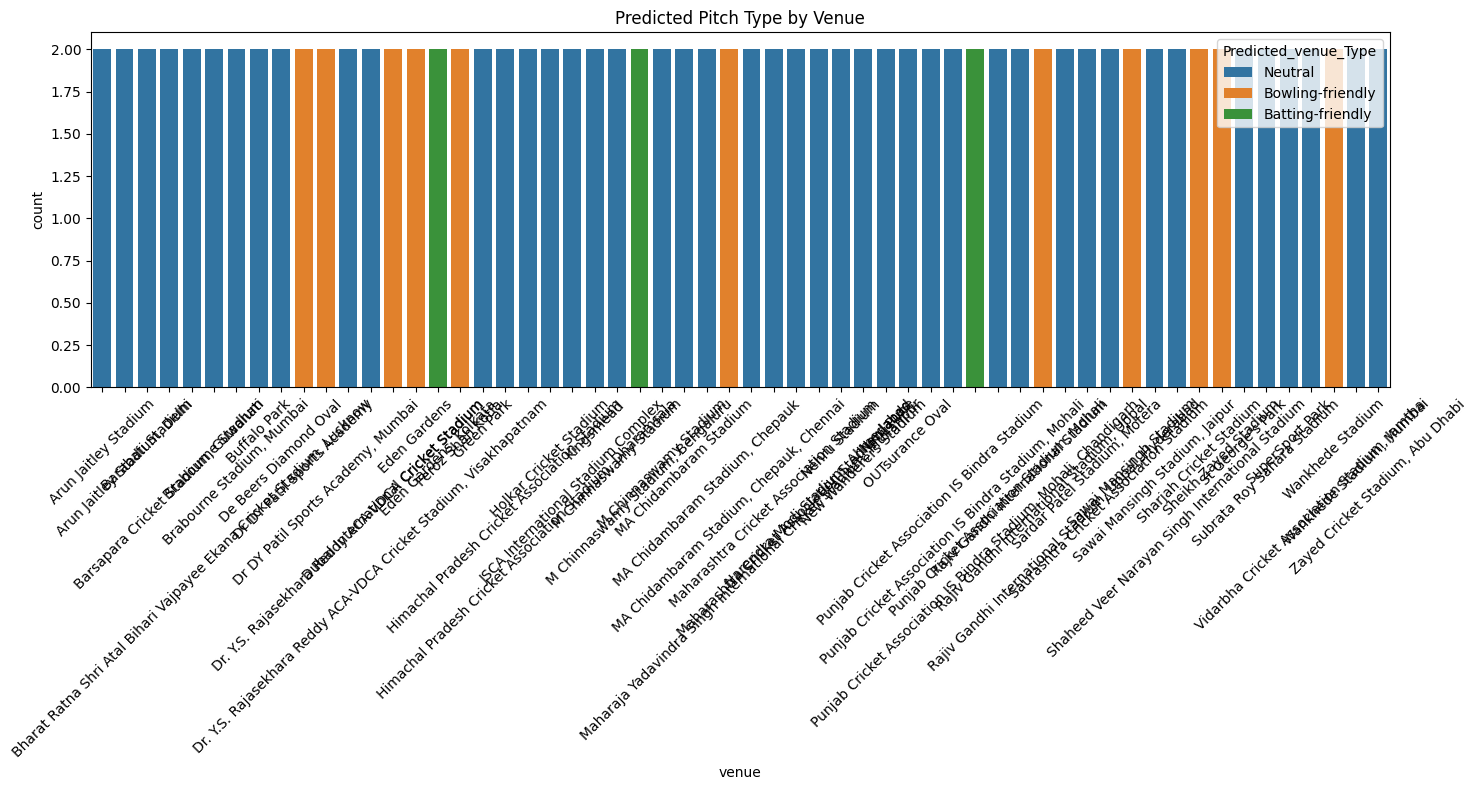

In [90]:
#Pitch Predictions by Venue
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))

# Ensure 'venue' column is in upcoming_data
upcoming_data = pd.merge(upcoming_data, merged_df[['venue']], left_index=True, right_index=True)

#Instead of merging, just copy the venue column
upcoming_data['venue'] = merged_df['venue']

sns.countplot(data=upcoming_data, x='venue', hue='Predicted_venue_Type')
plt.title("Predicted Pitch Type by Venue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

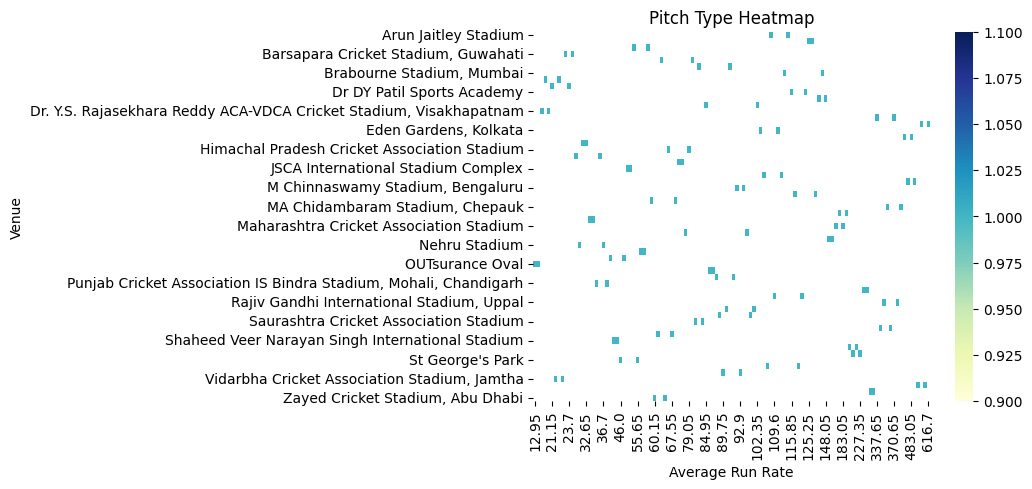

In [91]:
#Heatmap (e.g., Run Rate vs Dot Ball % vs Predicted Pitch Type)

pivot_table = upcoming_data.pivot_table(index='venue', columns='run_rate', values='Predicted_venue_Type', aggfunc='count')
sns.heatmap(pivot_table, cmap='YlGnBu')
plt.title("Pitch Type Heatmap")
plt.xlabel("Average Run Rate")
plt.ylabel("Venue")
plt.show()

### Export Model + Predictions

In [92]:
import joblib

# Save model
joblib.dump(rf_model, "smart_pitch_classifier.pkl")

# Export predictions
upcoming_data.to_csv("predicted_pitch_types.csv", index=False)

In [93]:
pitch = pd.read_csv('predicted_pitch_types.csv')

# **Fantasy Cricket AI Model**

In [94]:
# Batting Summary: Group by match and batter
batting_summary = df.groupby(['match_id', 'batter']).agg(
    runs_scored=('batsman_runs', 'sum'),
    balls_faced=('ball', 'count'),
    ones= ('batsman_runs', lambda x: (x == 1).sum()),
    twos=('batsman_runs', lambda x: (x == 2).sum()),
    threes=('batsman_runs', lambda x: (x == 3).sum()),
    fours=('batsman_runs', lambda x: (x == 4).sum()),
    sixes=('batsman_runs', lambda x: (x == 6).sum()),
    dismissals=('is_wicket', 'sum')  # Simplified for now
).reset_index()

# Calculate strike rate
batting_summary['strike_rate'] = (batting_summary['runs_scored'] / batting_summary['balls_faced']) * 100

In [95]:
# Filter only valid deliveries (excluding wides and no-balls for over count)
valid_deliveries = df[df['extras_type'].isnull()]

# Group by match and bowler
bowling_summary = valid_deliveries.groupby(['match_id', 'bowler']).agg(
    runs_conceded=('total_runs', 'sum'),
    deliveries_bowled=('ball', 'count'),
    wickets=('is_wicket', 'sum')
).reset_index()

# Calculate overs bowled and economy rate
bowling_summary['overs'] = bowling_summary['deliveries_bowled'] // 6 + (bowling_summary['deliveries_bowled'] % 6) / 10
bowling_summary['economy'] = bowling_summary['runs_conceded'] / (bowling_summary['deliveries_bowled'] / 6)

In [96]:
final_df = pd.merge(
    batting_summary,
    bowling_summary,
    how='outer',  # some players only bat or bowl
    left_on=['match_id', 'batter'],
    right_on=['match_id', 'bowler']
)

final_df.fillna({
    'runs_scored': 0,
    'balls_faced': 0,
    'fours': 0,
    'sixes': 0,
    'dismissals': 0,
    'strike_rate': 0,
    'runs_conceded': 0,
    'deliveries_bowled': 0,
    'wickets': 0,
    'overs': 0,
    'economy': 0
}, inplace=True)
final_df['player'] = final_df['batter'].combine_first(final_df['bowler'])

In [97]:
# Base batting points
final_df['batting_points'] = (
    final_df['runs_scored'] * 1 +
    final_df['fours'] * 1 +
    final_df['sixes'] * 2 +
    final_df['runs_scored'].apply(lambda x: 10 if 30 <= x < 50 else 0) +
    final_df['runs_scored'].apply(lambda x: 20 if 50 <= x < 100 else 0) +
    final_df['runs_scored'].apply(lambda x: 30 if x >= 100 else 0)
)

# Duck penalty
final_df['batting_points'] -= final_df.apply(
    lambda x: 2 if x['runs_scored'] == 0 and x['balls_faced'] > 0 else 0, axis=1
)

# Bowling points
final_df['bowling_points'] = (
    final_df['wickets'] * 25 +
    final_df['wickets'].apply(lambda x: 10 if x == 3 else (20 if x >= 4 else 0))
)

# Total fantasy points
final_df['total_fantasy_points'] = final_df['batting_points'] + final_df['bowling_points']


In [98]:
# Merge pitch data into the final_df (where venue is present)
fantasy_df = final_df.merge(
    df[['match_id', 'venue']],
    on='match_id',
    how='left'
).merge(
    pitch,
    on='venue',
    how='left'
)

In [99]:
df = df.drop_duplicates(subset=['match_id', 'venue'], keep='first')
pitch = pitch.drop_duplicates(subset=['venue'], keep='first')  # Assuming 'venue' is unique in 'pitch'

# Now proceed with your merging steps to create 'fantasy_df'
fantasy_df = final_df.merge(
    df[['match_id', 'venue']],
    on='match_id',
    how='left'
).merge(
    pitch,
    on='venue',
    how='left'
)

In [100]:
sf.head(1)

,bowler,role,bat_style,bowl_style,Unnamed: 4,Unnamed: 5
0,Z Khan,Bowler,Right Handed Bat,Left-arm fast-medium,NaN,NaN


In [101]:
sf.role.unique()

array([' Bowler ', 'WK-Batsman ', ' Batting Allrounder ', ' Batsman ',
       ' Bowling Allrounder ', ' -- ', ' WK-Batsman ', nan], dtype=object)

In [102]:
sf.rename(columns={'bowler': 'player'}, inplace=True)

   # Merge 'fantasy_df' and 'sf' on the 'player' column
fantasy_df = pd.merge(fantasy_df, sf, on='player', how='left')

In [103]:
fantasy_df[['match_id', 'player', 'total_fantasy_points', 'venue', 'Predicted_venue_Type', 'run_rate', 'powerplay_stats', 'role', 'bat_style', 'bowl_style', 'wickets', 'economy', 'overs', 'runs_scored', 'strike_rate']].head(2)

,match_id,player,total_fantasy_points,venue,Predicted_venue_Type,run_rate,powerplay_stats,role,bat_style,bowl_style,wickets,economy,overs,runs_scored,strike_rate
0,335982,AA Noffke,35.0,M Chinnaswamy Stadium,Neutral,546.2,5912,Bowler,Right Handed Bat,Right-arm fast-medium,1.0,9.130435,3.5,9.0,75.0
1,335982,AB Agarkar,85.0,M Chinnaswamy Stadium,Neutral,546.2,5912,Bowler,Right Handed Bat,Right-arm fast-medium,3.0,5.250000,4.0,0.0,0.0


##ML Code Setup

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Select relevant features and drop rows with missing values
model_df = fantasy_df[[
    'runs_scored', 'strike_rate', 'fours', 'sixes',
    'wickets', 'economy', 'overs',
    'Predicted_venue_Type', 'role', 'bat_style', 'bowl_style'
]].copy()
model_df['total_fantasy_points'] = fantasy_df['total_fantasy_points']

# One-hot encode categorical features
model_df = pd.get_dummies(model_df, columns=['Predicted_venue_Type', 'role', 'bat_style', 'bowl_style'])

# Drop any remaining NaNs
model_df = model_df.dropna()

# Split into features and target
X = model_df.drop('total_fantasy_points', axis=1)
y = model_df['total_fantasy_points']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MAE: 0.3280213915766669
R² Score: 0.9977307167169672


In [105]:
import joblib

# Save the trained model
joblib.dump(model, 'fantasy_rf_model.pkl')

# Save the feature column names
joblib.dump(X.columns.tolist(), 'fantasy_rf_features.pkl')

['fantasy_rf_features.pkl']

In [106]:
import numpy as np

# Step 1: Average fantasy points per player
avg_points = fantasy_df.groupby('player')['total_fantasy_points'].mean().reset_index()
avg_points.columns = ['player', 'avg_fantasy_points']

# Step 2: Assign synthetic credits
def assign_credits(avg_pts):
    if avg_pts >= 60:
        return round(np.random.uniform(9.5, 10.0), 1)
    elif avg_pts >= 40:
        return round(np.random.uniform(8.5, 9.4), 1)
    elif avg_pts >= 25:
        return round(np.random.uniform(7.5, 8.4), 1)
    else:
        return round(np.random.uniform(6.5, 7.4), 1)

avg_points['credits'] = avg_points['avg_fantasy_points'].apply(assign_credits)

# Merge back with fantasy_df to have credits per player
fantasy_df = fantasy_df.merge(avg_points[['player', 'credits']], on='player', how='left')

# Preview
fantasy_df[['player', 'total_fantasy_points', 'credits']].drop_duplicates().head(10)

,player,total_fantasy_points,credits
0,AA Noffke,35.0,7.6
1,AB Agarkar,85.0,8.0
2,AB Dinda,50.0,8.3
3,B Akhil,-2.0,6.8
4,BB McCullum,224.0,7.8
5,CL White,6.0,7.9
6,DJ Hussey,13.0,7.6
7,I Sharma,25.0,7.2
8,JH Kallis,35.0,8.9
9,LR Shukla,25.0,6.5


## Optimize Best Fantasy XI

In [107]:
!pip install pulp

In [108]:
import pulp

# Step 1: Take the latest match for each player or average prediction (simplified here)
latest_player_data = fantasy_df.groupby('player').agg({
    'total_fantasy_points': 'mean',
    'credits': 'mean',
    'role': 'first'  # assuming role is consistent per player
}).reset_index()

# Step 2: Create optimization problem
prob = pulp.LpProblem("Fantasy_XI_Optimization", pulp.LpMaximize)

# Step 3: Decision variables: 1 if player is selected, 0 otherwise
player_vars = {row['player']: pulp.LpVariable(f"select_{row['player']}", cat='Binary')
               for _, row in latest_player_data.iterrows()}

# Step 4: Objective: Maximize total predicted points
prob += pulp.lpSum(player_vars[p] * row['total_fantasy_points']
                   for p, row in latest_player_data.set_index('player').iterrows())

# Step 5: Constraint: Select exactly 11 players
prob += pulp.lpSum(player_vars.values()) == 11

# Step 6: Credit cap (e.g., max 100)
prob += pulp.lpSum(player_vars[p] * row['credits']
                   for p, row in latest_player_data.set_index('player').iterrows()) <= 100


# Step 7: Role constraints
role_counts = latest_player_data.groupby('role')['player'].apply(list).to_dict()

# Exactly 3 bowlers
if 'Bowler' in role_counts:
    prob += pulp.lpSum([player_vars[p] for p in role_counts['Bowler']]) == 3

# Exactly 3 all-rounders
if 'All-Rounder' in role_counts:
    prob += pulp.lpSum([player_vars[p] for p in role_counts['All-Rounder']]) == 3

# Exactly 1 wicket-keeper
if 'WK-Batsman' in role_counts:
    prob += pulp.lpSum([player_vars[p] for p in role_counts['WK-Batsman']]) == 1

# Exactly 4 batsmen
if 'Batter' in role_counts:
    prob += pulp.lpSum([player_vars[p] for p in role_counts['Batter']]) == 4

# Step 8: Solve
prob.solve()

# Step 9: Extract selected team
selected_players = [p for p in player_vars if player_vars[p].value() == 1]
fantasy_xi = latest_player_data[latest_player_data['player'].isin(selected_players)].sort_values(by='total_fantasy_points', ascending=False)

fantasy_xi[['player', 'role', 'credits', 'total_fantasy_points']]

,player,role,credits,total_fantasy_points
157,DAJ Bracewell,Bowler,9.5,98.000000
683,Vivrant Sharma,None,9.9,88.000000
664,Umar Gul,Bowler,9.9,73.333333
628,Sohail Tanvir,Bowler,9.6,65.545455
92,Azhar Mahmood,Bowling Allrounder,8.7,58.434783
55,AP Dole,Bowler,8.6,58.000000
369,MF Maharoof,Batting Allrounder,8.6,54.900000
334,LMP Simmons,Batsman,8.8,54.034483
30,AB McDonald,Batting Allrounder,8.9,53.800000
131,CH Gayle,Batsman,8.6,53.673759


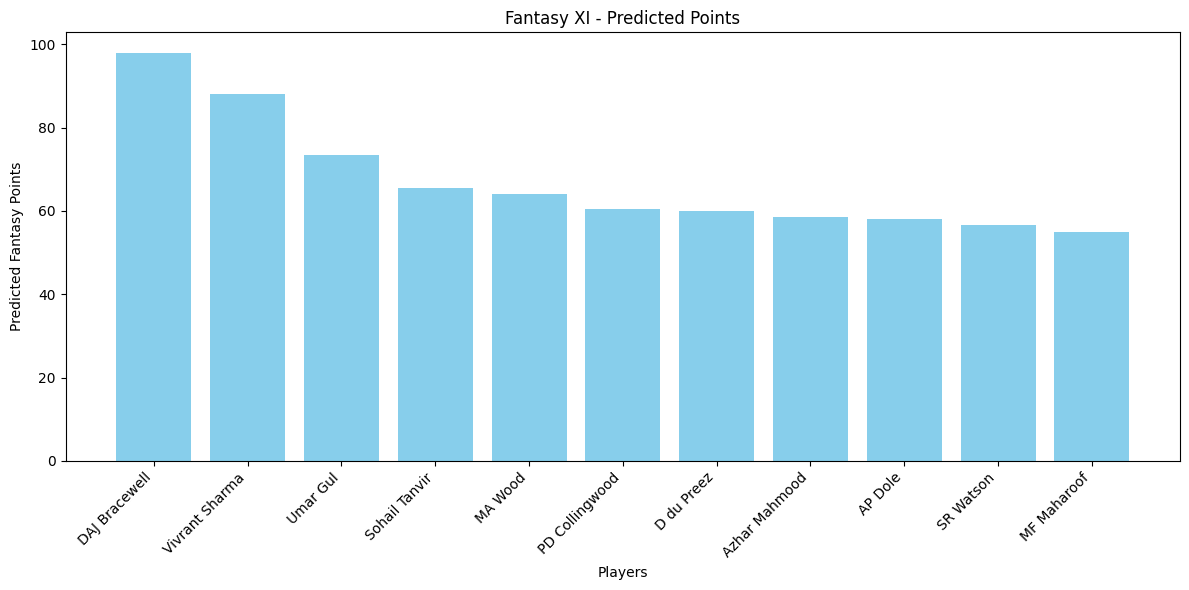

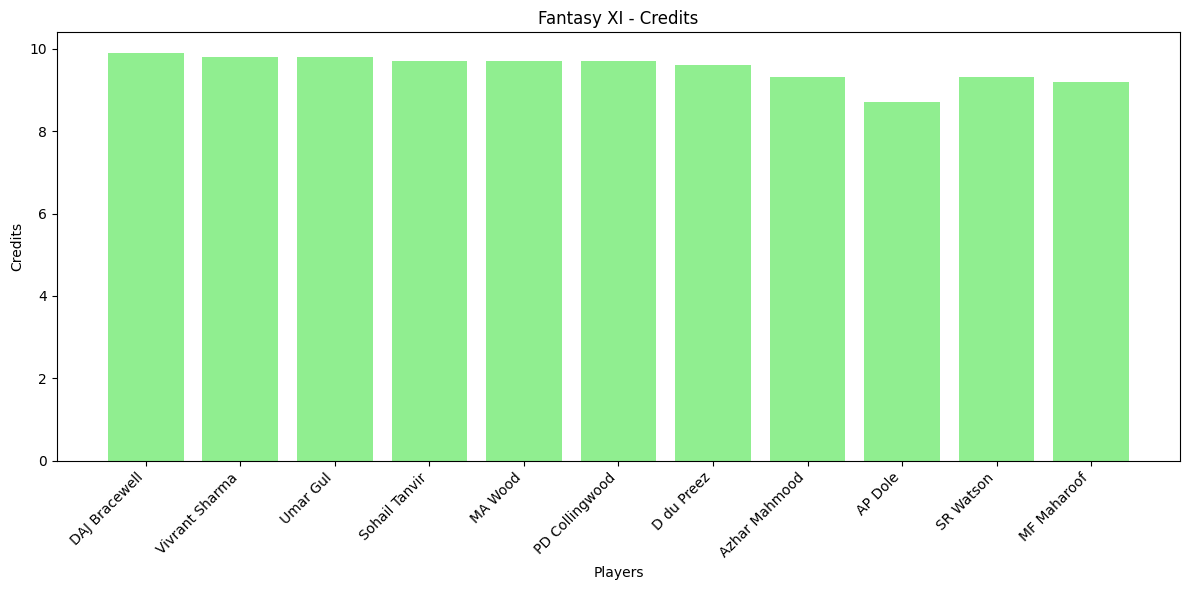

In [117]:
#Visualization:
plt.figure(figsize=(12, 6))

# Bar chart of total fantasy points
plt.bar(fantasy_xi['player'], fantasy_xi['total_fantasy_points'], color='skyblue')
plt.xlabel("Players")
plt.ylabel("Predicted Fantasy Points")
plt.title("Fantasy XI - Predicted Points")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 6))
plt.bar(fantasy_xi['player'], fantasy_xi['credits'], color='lightgreen')
plt.xlabel("Players")
plt.ylabel("Credits")
plt.title("Fantasy XI - Credits")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Objective: Build a data-driven Fantasy XI Optimizer

Today was all about translating insights into real impact — like how professional teams or fantasy apps build their match-winning lineups.

✅ We began by merging player stats with pitch behavior and style
✅ Predicted fantasy points using machine learning
✅ Used linear programming to select the best XI under 100 credits
✅ Ensured the ideal role balance (5 batters incl. 1 WK, 4 bowlers, 2 all-rounders)
✅ Visualized the final XI by predicted points and credits

It felt like being a real match analyst — every player had to earn their place.

Key Takeaways:

Sports analytics is more than numbers — it’s strategic decision-making

Constraint-based optimization is incredibly powerful in fantasy and team selection

Pitch-aware, role-specific team builds can massively boost fantasy scores